In [1]:
import os
!pip install statsmodels
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from pymongo import MongoClient
from pprint import pprint



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
client = MongoClient(os.environ["ECOMMERCE__CONNECTION_STRING"])
db = client["ecommerce"]
serverStatusResult = db.command("serverStatus")
pprint(serverStatusResult)

{'$clusterTime': {'clusterTime': Timestamp(1733793093, 39),
                  'signature': {'hash': b'(\x12\xcc`+b\xdb\xc2\x90\xfdy3'
                                        b'\xeaz\xacU\x1b\xbe\xaen',
                                'keyId': 7389295562647928840}},
 'asserts': {'msg': 0, 'regular': 0, 'rollovers': 0, 'user': 0, 'warning': 0},
 'atlasVersion': {'gitVersion': '187c4553b9ee076e86218fd2076914ae11ecc113',
                  'version': '20241113.0.0.1731341512'},
 'connections': {'available': 496, 'current': 4, 'totalCreated': 446},
 'extra_info': {'note': 'fields vary by platform', 'page_faults': 0},
 'host': 'cluster0-shard-00-02.zf6aq.mongodb.net:27017',
 'localTime': datetime.datetime(2024, 12, 10, 1, 11, 33, 920000),
 'mem': {'bits': 64,
         'mapped': 0,
         'mappedWithJournal': 0,
         'resident': 0,
         'supported': True,
         'virtual': 0},
 'metrics': {'aggStageCounters': {'search': 0,
                                  'searchBeta': 0,
        

In [3]:
# Convert MongoDB data to Pandas DataFrame
sales_report = db['Amazon-Sale-Report'].find()
df = pd.DataFrame(list(sales_report))
print(df.columns)

Index(['_id', 'Order ID', 'Date', 'Status', 'Fulfilment', 'Sales Channel ',
       'ship-service-level', 'Style', 'SKU', 'Category', 'Size', 'ASIN', 'Qty',
       'currency', 'Amount', 'ship-city', 'ship-state', 'ship-postal-code',
       'ship-country', 'B2B', 'fulfilled-by', 'Courier Status',
       'promotion-ids', 'Unnamed: 22'],
      dtype='object')


In [13]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)


df_daily = df.groupby('Date').agg({'Amount': 'sum', 'Qty': 'sum', 'B2B': 'sum'}).reset_index()


train, test = train_test_split(df_daily, test_size=0.2, shuffle=False)


endog = train['Amount']
exog = train[['Qty', 'B2B']]


test_exog = test[['Qty', 'B2B']]


model = SARIMAX(endog, exog=exog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarimax_result = model.fit(disp=False)


pred = sarimax_result.get_forecast(steps=len(test), exog=test_exog)
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int()

#Evaluation Metrics
mse = mean_squared_error(test['Amount'], pred_mean)
mae = mean_absolute_error(test['Amount'], pred_mean)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


import plotly.graph_objects as go

# Create the plotly figure
fig = go.Figure()

# Plot the training data
fig.add_trace(go.Scatter(x=train['Date'], y=train['Amount'], mode='lines', name='Training Data', line=dict(color='blue', width=2), opacity=0.6))

# Plot the test data
fig.add_trace(go.Scatter(x=test['Date'], y=test['Amount'], mode='lines', name='Test Data', line=dict(color='orange', width=2), opacity=0.8))

# Plot the forecasted values
fig.add_trace(go.Scatter(x=test['Date'], y=pred_mean, mode='lines', name='Forecast', line=dict(color='red', dash='dash', width=2)))

# Add a vertical line to separate training and testing data
fig.add_trace(go.Scatter(
    x=[train['Date'].iloc[-1], train['Date'].iloc[-1]], 
    y=[min(test['Amount']), max(test['Amount'])], 
    mode='lines', line=dict(color='black', dash='dash', width=2),
    name='Train-Test Split'))

# Add hover data for actual and forecast only
fig.update_traces(
    hovertemplate="<b>Actual:</b> %{y}<br><b>Forecast:</b> %{text}",
    hoverinfo="y+text",  # Only show y (Actual) and text (Forecast) in hover info
    text=pred_mean  # Forecast values
)

# Add evaluation metrics to the plot (displayed below the graph)
fig.add_annotation(
    x=0.5, y=-0.12, xref="paper", yref="paper",  # Adjusted y for better visibility inside the graph
    text=f"RMSE: {rmse:.2f} | MAE: {mae:.2f} | MSE: {mse:.2f}",
    showarrow=False, font=dict(size=14, color="black"),
    align="center", bgcolor="white", opacity=0.7
)

# Enhance the plot aesthetics
fig.update_layout(
    title="SARIMAX Sales Forecast vs Actual",
    xaxis_title="Date",
    yaxis_title="Sales Amount",
    legend_title="Legend",
    legend=dict(x=0.01, y=0.85),  # Moved the legend down within the plot
    template="plotly",
    hovermode="x unified",
    margin=dict(l=60, r=60, b=180, t=60),  # Adjusted bottom margin further for space
    showlegend=True
)

# Show the plot
fig.show()


Mean Absolute Error (MAE): 18314.97
Mean Squared Error (MSE): 584076994.38
Root Mean Squared Error (RMSE): 24167.68


In [5]:
print(len(df))

128976


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split


df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)


df_daily = df.groupby('Date').agg({'Amount': 'sum', 'Qty': 'sum', 'B2B': 'sum'}).reset_index()


train, test = train_test_split(df_daily, test_size=0.2, shuffle=False)


endog = train['Amount']
exog = train[['Qty', 'B2B']]


test_exog = test[['Qty', 'B2B']]


model = SARIMAX(endog, exog=exog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarimax_result = model.fit(disp=False)


test_pred = sarimax_result.get_prediction(start=test.index[0], end=test.index[-1], exog=test_exog)
test_pred_mean = test_pred.predicted_mean
test_pred_ci = test_pred.conf_int()

n_steps = 30
future_dates = pd.date_range(start=test['Date'].max(), periods=n_steps + 1, freq='D')[1:]
future_exog = test_exog.iloc[-1:]
future_exog = pd.concat([future_exog] * n_steps, ignore_index=True)


forecast = sarimax_result.get_forecast(steps=n_steps, exog=future_exog)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Evaluation Metrics
mse = mean_squared_error(test['Amount'], test_pred_mean)
mae = mean_absolute_error(test['Amount'], test_pred_mean)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


# plt.figure(figsize=(12, 6))
# plt.plot(train['Date'], train['Amount'], label='Training Data', color='blue')
# plt.plot(test['Date'], test['Amount'], label='Test Data', color='green')
# plt.plot(test['Date'], test_pred_mean, label='Test Prediction Points', color='red')
# plt.fill_between(test['Date'], test_pred_ci.iloc[:, 0], test_pred_ci.iloc[:, 1], color='red', alpha=0.3)


# plt.plot(future_dates, forecast_mean, label='Future Forecasted Points ', color='orange')
# plt.fill_between(future_dates, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='orange', alpha=0.3)

# plt.xlabel('Date')
# plt.ylabel('Sales Amount')
# plt.title('SARIMAX Model: Test Predictions Results and Future Forecasted Predicitions')
# plt.legend()
# plt.grid()
# plt.show()


Mean Absolute Error (MAE): 18314.97
Mean Squared Error (MSE): 584076994.38
Root Mean Squared Error (RMSE): 24167.68


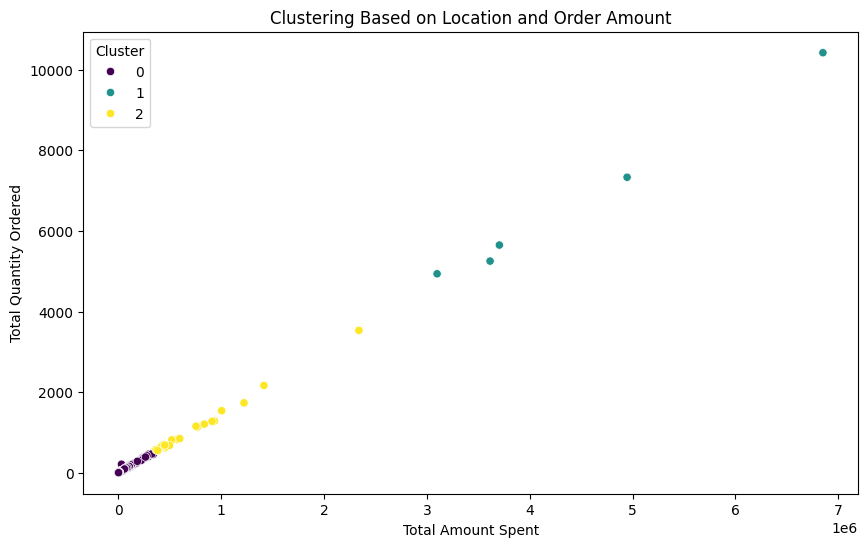

In [7]:
location_data = df.groupby(['ship-city']).agg(
    total_amount_spent=('Amount', 'sum'),
    total_qty_ordered=('Qty', 'sum')
).reset_index()


scaler = StandardScaler()
scaled_features = scaler.fit_transform(location_data[['total_amount_spent', 'total_qty_ordered']])


kmeans = KMeans(n_clusters=3, random_state=42)
location_data['Cluster'] = kmeans.fit_predict(scaled_features)


plt.figure(figsize=(10, 6))
sns.scatterplot(data=location_data, x='total_amount_spent', y='total_qty_ordered', hue='Cluster', palette='viridis')
plt.title('Clustering Based on Location and Order Amount')
plt.xlabel('Total Amount Spent')
plt.ylabel('Total Quantity Ordered')
plt.legend(title='Cluster')
plt.show()


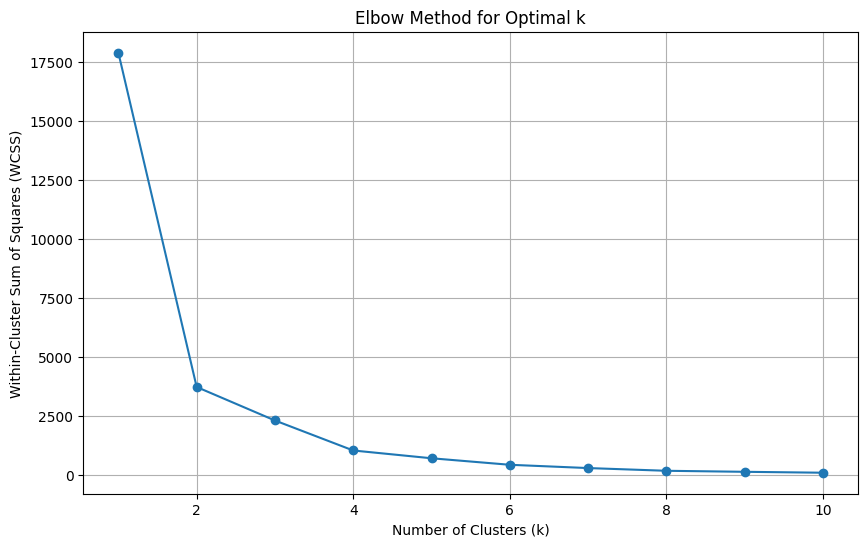

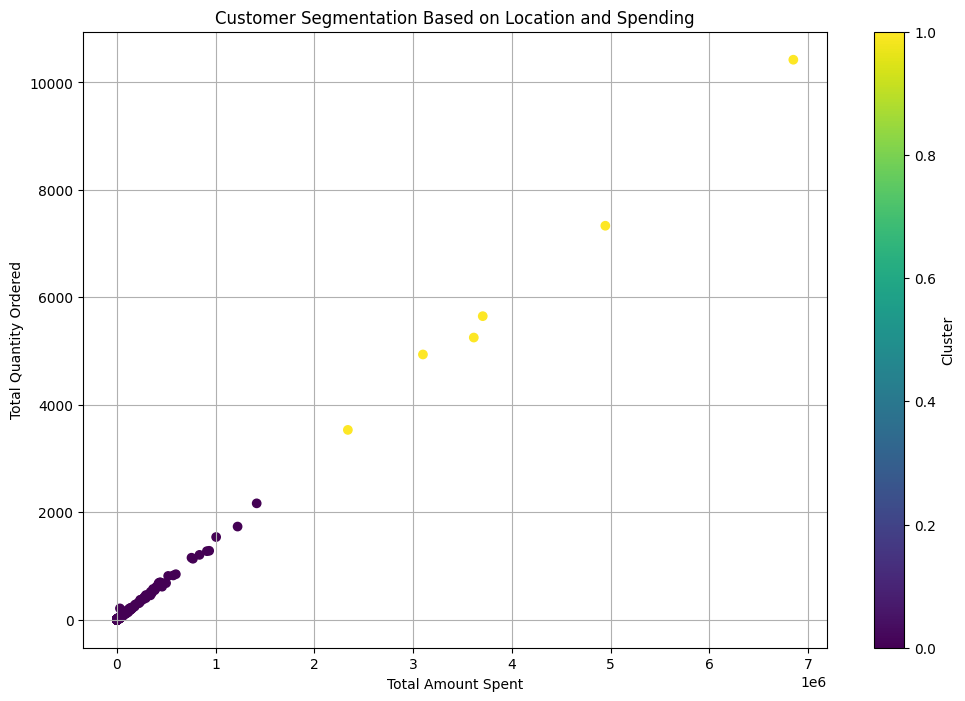

In [8]:

location_data = df.groupby('ship-city').agg(
    total_amount_spent=('Amount', 'sum'),
    total_qty_ordered=('Qty', 'sum')
).reset_index()


scaler = StandardScaler()
scaled_features = scaler.fit_transform(location_data[['total_amount_spent', 'total_qty_ordered']])


wcss = []
range_n_clusters = range(1, 11)

for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

# Elbow
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, wcss, marker='o', linestyle='-')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.show()


optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
location_data['Cluster'] = kmeans.fit_predict(scaled_features)

# Step 5: Evaluation with Silhouette Score
silhouette_avg = silhouette_score(scaled_features, location_data['Cluster'])



plt.figure(figsize=(12, 8))
plt.scatter(location_data['total_amount_spent'], location_data['total_qty_ordered'],
            c=location_data['Cluster'], cmap='viridis', marker='o')
plt.xlabel('Total Amount Spent')
plt.ylabel('Total Quantity Ordered')
plt.title('Customer Segmentation Based on Location and Spending')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()


In [9]:
print(f"Silhouette Score for k={optimal_k}: {silhouette_avg:.2f}")

Silhouette Score for k=2: 1.00


In [10]:
location_data = df.groupby('ship-city').agg(
    total_amount_spent=('Amount', 'sum'),
    total_qty_ordered=('Qty', 'sum')
).reset_index()


location_data.describe()


,total_amount_spent,total_qty_ordered
count,8.955000e+03,8955.000000
mean,8.774362e+03,13.023116
std,1.190145e+05,179.435821
min,0.000000e+00,0.000000
25%,5.680000e+02,1.000000
50%,1.014000e+03,1.000000
75%,2.409000e+03,3.000000
max,6.850071e+06,10423.000000


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e322a799-a681-4754-b873-85c47d774f17' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>